current working directory:  C:\Users\s_renaud\Documents\GitHub\MSCSAM_TBD\main_model
working on:  checkpointz\to_slurm\aae_latent128\300_aae-128_peptide.ckpt 

aae-128_peptide
working on:  checkpointz\to_slurm\aae_latent32\300_aae-128_peptide.ckpt 

aae-128_peptide


C:\Users\s_renaud\Documents\GitHub\MSCSAM_TBD\main_model\transvae\trans_models.py:54: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



working on:  checkpointz\to_slurm\aae_latent64\300_aae-128_peptide.ckpt 

aae-128_peptide


C:\Users\s_renaud\Documents\GitHub\MSCSAM_TBD\main_model\transvae\trans_models.py:54: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



working on:  checkpointz\to_slurm\rnnattn_latent128\300_rnnattn-128_peptide.ckpt 

rnnattn-128_peptide
working on:  checkpointz\to_slurm\rnnattn_latent32\300_rnnattn-128_peptide.ckpt 



C:\Users\s_renaud\Documents\GitHub\MSCSAM_TBD\main_model\transvae\trans_models.py:54: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



rnnattn-128_peptide
working on:  checkpointz\to_slurm\rnnattn_latent64\300_rnnattn-128_peptide.ckpt 



C:\Users\s_renaud\Documents\GitHub\MSCSAM_TBD\main_model\transvae\trans_models.py:54: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



rnnattn-128_peptide
working on:  checkpointz\to_slurm\rnn_latent128\300_rnn-128_peptide.ckpt 

rnn-128_peptide
working on:  checkpointz\to_slurm\rnn_latent32\300_rnn-128_peptide.ckpt 



C:\Users\s_renaud\Documents\GitHub\MSCSAM_TBD\main_model\transvae\trans_models.py:54: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



rnn-128_peptide
working on:  checkpointz\to_slurm\rnn_latent64\300_rnn-128_peptide.ckpt 



C:\Users\s_renaud\Documents\GitHub\MSCSAM_TBD\main_model\transvae\trans_models.py:54: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



rnn-128_peptide
working on:  checkpointz\to_slurm\trans_latent128\300_trans1x-128_peptide.ckpt 

trans1x-128_peptide
working on:  checkpointz\to_slurm\trans_latent32\300_trans1x-128_peptide.ckpt 



C:\Users\s_renaud\Documents\GitHub\MSCSAM_TBD\main_model\transvae\trans_models.py:54: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



trans1x-128_peptide
working on:  checkpointz\to_slurm\trans_latent64\300_trans1x-128_peptide.ckpt 



C:\Users\s_renaud\Documents\GitHub\MSCSAM_TBD\main_model\transvae\trans_models.py:54: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



trans1x-128_peptide
working on:  checkpointz\to_slurm\wae_latent128\300_wae-128_peptide.ckpt 

WAE class init called /n
WAE class build_model called /n
wae-128_peptide
working on:  checkpointz\to_slurm\wae_latent32\300_wae-128_peptide.ckpt 

WAE class init called /n
WAE class build_model called /n


C:\Users\s_renaud\Documents\GitHub\MSCSAM_TBD\main_model\transvae\trans_models.py:54: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



wae-128_peptide
working on:  checkpointz\to_slurm\wae_latent64\300_wae-128_peptide.ckpt 

WAE class init called /n
WAE class build_model called /n
wae-128_peptide


C:\Users\s_renaud\Documents\GitHub\MSCSAM_TBD\main_model\transvae\trans_models.py:54: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



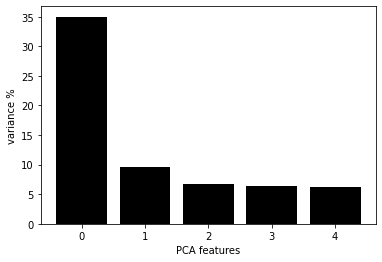

In [1]:
import numpy as np
import random
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from transvae import trans_models
from transvae.transformer_models import TransVAE
from transvae.rnn_models import RNN, RNNAttn
from transvae.wae_models import WAE
from transvae.aae_models import AAE
from transvae.tvae_util import *
from transvae import analysis
import glob
import re

from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn import metrics
from sklearn.manifold import trustworthiness
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import plotly.express as px
import plotly.graph_objects as go

import coranking #coranking.readthedocs.io
from coranking.metrics import trustworthiness, continuity, LCMC
from transvae.snc import SNC #github.com/hj-n/steadiness-cohesiveness

import Bio
from Bio import pairwise2
from Bio.Align import substitution_matrices

def loss_plots(loss_src):
    tot_loss = analysis.plot_loss_by_type(src,loss_types=['tot_loss'])
    plt.savefig(save_dir+'tot_loss.png')
    recon_loss = analysis.plot_loss_by_type(src,loss_types=['recon_loss'])
    plt.savefig(save_dir+'recon_loss.png')
    kld_loss = analysis.plot_loss_by_type(src,loss_types=['kld_loss'])
    plt.savefig(save_dir+'kld_loss.png')
    prob_bce_loss = analysis.plot_loss_by_type(src,loss_types=['prop_bce_loss'])
    plt.savefig(save_dir+'prob_bce_loss.png')
    if 'aae' in src:
        disc_loss = analysis.plot_loss_by_type(src,loss_types=['disc_loss'])
        plt.savefig(save_dir+'disc_loss.png')
    if 'wae' in src:
        mmd_loss = analysis.plot_loss_by_type(src,loss_types=['mmd_loss'])
        plt.savefig(save_dir+'mmd_loss.png')
    plt.close('all')
    
def load_reconstructions(data,data_1D,latent_size, load_src, true_props=None,subset=None):
    
    recon_src = load_src+model.name+"_"+re.split('(\d{2,3})',latent_size[0])[0]+"_"+re.split('(\d{2,3})',latent_size[0])[1]+"//saved_info.csv"
    recon_df = pd.read_csv(recon_src)
    reconstructed_seq = recon_df['reconstructions'].to_list()[:num_sequences]
    props = torch.Tensor(recon_df['predicted properties'][:num_sequences])
    true_props_data = pd.read_csv(true_props).to_numpy()
    true_props = true_props_data[0:num_sequences,0]
    
    if subset:
        testing = pd.read_csv(subset).to_numpy()
        test_idx_list = [np.where(data==testing[idx][0]) for idx in range(len(testing))]


        batch_recon_len = len(reconstructed_seq)
        reconstructed_seq = [reconstructed_seq[test_idx_list[i][0][0]] for i in range(len(test_idx_list)) if test_idx_list[i][0][0]<batch_recon_len]
        data_1D= [data_1D[test_idx_list[i][0][0]] for i in range(len(test_idx_list)) if test_idx_list[i][0][0]<batch_recon_len]
        props = [props[test_idx_list[i][0][0]] for i in range(len(test_idx_list)) if test_idx_list[i][0][0]<batch_recon_len]
        props=torch.Tensor(props)
        data = testing[:][0]
        true_props_data = pd.read_csv(true_props).to_numpy()
        true_props = true_props_data[0:num_sequences,0]
        true_props= [true_props[test_idx_list[i][0][0]] for i in range(len(test_idx_list)) if test_idx_list[i][0][0]<batch_recon_len]

    return data, data_1D, true_props, props, reconstructed_seq

########################################################################################
gpu = True

num_sequences = 500#_000
batch_size = 200 #setting for reconstruction
example_data = 'data\\peptides\\datasets\\uniprot_v2\\peptide_train.txt'
save_dir_loc = 'model_analyses\\train\\' #folder in which to save outpts
save_dir_name = 'train' #appended to identify data: train|test|other|etc...

reconstruct=True #True:reconstruct data here; False:load reconstructions from file
recon_src = "checkpointz//analyses_ckpts//" #directory in which all reconstructions are stored
true_prop_src = 'data\\peptides\\datasets\\uniprot_v2\\function_train.txt' #if property predictor load the true labels
subset_src = "" #(optional) this file should have the true sequences for a subset of the "example data" above

ckpt_list = glob.glob(""+"checkpointz\\to_slurm//**//*.ckpt", recursive = True) #grab all checkpoint
print('current working directory: ',os.getcwd())


for i in range(len(ckpt_list)):
    
    #search the current directory for the model name and load that model
    model_dic = {'trans':'TransVAE','aae':'AAE','rnnattn':'RNNAttn','rnn':'RNN','wae':'WAE'}
    model_src = ckpt_list[i]
    print('working on: ',model_src,'\n')
    model_name = list(filter(None,[key for key in model_dic.keys() if key in model_src.split('\\')[-1]]))
    model = locals()[model_dic[model_name[0]]](load_fn=model_src) #use locals to call model specific constructor
    
    #create save directory for the current model according to latent space size
    latent_size = re.findall('(latent[\d]{2,3})', model_src)
    save_dir= save_dir_loc+model.name+"_"+latent_size[0]+"_"+save_dir_name
    if not os.path.exists(save_dir):os.mkdir(save_dir) 
    save_dir= save_dir+"//" 
    save_df = pd.DataFrame() #this will hold the number variables and save to CSV
    
    #load the true labels
    data = pd.read_csv(example_data).to_numpy() 
    data_1D = data[:num_sequences,0] #gets rid of extra dimension
    true_props_data = pd.read_csv(true_prop_src).to_numpy()
    true_props = true_props_data[0:num_sequences,0]

    
#     #get the log.txt file from the ckpt and model name then plot loss curves
#     loss_src = '_'.join( ("log",model_src.split('\\')[-1].split('_')[1],model_src.split('\\')[-1].split('_')[2][:-4]+"txt") )
#     src= '\\'.join([str(i) for i in model_src.split('\\')[:-1]])+"\\"+loss_src
#     print(loss_src, src)
#     loss_plots(src)
    
#     #set the batch size and reconstruct the data
#     model.params['BATCH_SIZE'] = batch_size
#     if reconstruct:
#         reconstructed_seq, props = model.reconstruct(data[:num_sequences], log=False, return_mems=False)
#     else:
#         data, data_1D, true_props, props, reconstructed_seq = load_reconstructions(data, data_1D,latent_size,
#                                                                                    load_src=recon_src,
#                                                                                    true_props=true_prop_src)
#     if gpu:torch.cuda.empty_cache() #free allocated CUDA memory
    
#     #save the metrics to the dataframe
#     save_df['reconstructions'] = reconstructed_seq #placing the saves on a line separate from the ops allows for editing
#     save_df['predicted properties'] = [prop.item() for prop in props[:len(reconstructed_seq)]]
#     prop_acc, prop_conf, MCC=calc_property_accuracies(props[:len(reconstructed_seq)],true_props[:len(reconstructed_seq)], MCC=True)
#     save_df['property prediction accuracy'] = prop_acc
#     save_df['property prediction confidence'] = prop_conf
#     save_df['MCC'] = MCC
    

# #   First we tokenize the input and reconstructed smiles
#     input_sequences = []
#     for seq in data_1D:
#         input_sequences.append(peptide_tokenizer(seq))
#     output_sequences = []
#     for seq in reconstructed_seq:
#         output_sequences.append(peptide_tokenizer(seq))
    
#     seq_accs, tok_accs, pos_accs, seq_conf, tok_conf, pos_conf = calc_reconstruction_accuracies(input_sequences, output_sequences)
#     save_df['sequence accuracy'] = seq_accs
#     save_df['sequence confidence'] = seq_conf
#     save_df['token accuracy'] = tok_accs
#     save_df['token confidence'] = tok_conf
#     save_df = pd.concat([pd.DataFrame({'position_accs':pos_accs,'position_confidence':pos_conf }), save_df], axis=1)
    
    ##moving into memory and entropy
    if model.model_type =='aae':
        mus, _, _ = model.calc_mems(data[:50_000], log=False, save=False) 
    elif model.model_type == 'wae':
        mus, _, _ = model.calc_mems(data[:50_000], log=False, save=False) 
    else:
        mems, mus, logvars = model.calc_mems(data[:50_000], log=False, save=False) #subset size 1200*35=42000 would be ok

#     ##calculate the entropies
#     vae_entropy_mus = calc_entropy(mus)
#     save_df = pd.concat([save_df,pd.DataFrame({'mu_entropies':vae_entropy_mus})], axis=1)
#     if model.model_type != 'wae' and model.model_type!= 'aae': #these don't have a variational type bottleneck
#         vae_entropy_mems  = calc_entropy(mems)
#         save_df = pd.concat([save_df,pd.DataFrame({'mem_entropies':vae_entropy_mems})], axis=1)
#         vae_entropy_logvars = calc_entropy(logvars)
#         save_df = pd.concat([save_df,pd.DataFrame({'logvar_entropies':vae_entropy_logvars})], axis=1)
    


    #create random index and re-index ordered memory list creating n random sub-lists (ideally resulting in IID random lists)
    random_idx = np.random.permutation(np.arange(stop=mus.shape[0]))
    mus = mus[random_idx]
    data = data[random_idx]

    subsample_start=0
    subsample_length=mus.shape[0] #this may change depending on batch size

    #(for length based coloring): record all peptide lengths iterating through input
    pep_lengths = []
    for idx, pep in enumerate(data[subsample_start:(subsample_start+subsample_length)]):
        pep_lengths.append( len(pep[0]) )   
    #(for function based coloring): pull function from csv with peptide functions
    s_to_f =pd.read_csv(true_prop_src)    
    function = s_to_f['peptides'][subsample_start:(subsample_start+subsample_length)]
    function = function[random_idx] #account for random permutation

    pca = PCA(n_components=5)
    pca_batch =pca.fit_transform(X=mus[:])

    #plot format dictionnaries
    titles={'text':'{}'.format(model.model_type.replace("_"," ").upper()),
                          'x':0.5,'xanchor':'center','yanchor':'top','font_size':40}
    general_fonts={'family':"Helvetica",'size':30,'color':"Black"}
    colorbar_fmt={'title_font_size':30,'thickness':15,'ticks':'','title_text':'Lengths',
                               'ticklabelposition':"outside bottom"}
    
    fig = px.scatter(pd.DataFrame({"PC1":pca_batch[:,0],"PC2":pca_batch[:,1], "lengths":pep_lengths}),
                symbol_sequence=['hexagon2'],x='PC1', y='PC2', color="lengths",
                color_continuous_scale='Jet',template='simple_white', opacity=0.9)
    fig.update_traces(marker=dict(size=9))
    fig.update_layout(title=titles,xaxis_title="PC1", yaxis_title="PC2",font=general_fonts)
    fig.update_coloraxes(colorbar=colorbar_fmt)
    fig.write_image(save_dir+'pca_length.png', width=900, height=600)

    fig = px.scatter(pd.DataFrame({"PC1":pca_batch[:,0],"PC2":pca_batch[:,1], 
                                    "Function":list(map(lambda itm: "AMP" if itm==1 else "NON-AMP",function))}),
                                    x='PC1', y='PC2', color="Function",symbol_sequence=['x-thin-open','circle'],
                                    template='simple_white',symbol='Function', opacity=0.8) 
    fig.update_traces(marker=dict(size=9))
    fig.update_layout(title=titles,xaxis_title="PC1",yaxis_title="PC2",font=general_fonts)
    fig.write_image(save_dir+'pca_function.png', width=900, height=600)
    
    # Plot the explained variances
    plt.bar(range(pca.n_components_), pca.explained_variance_ratio_*100, color='black')
    plt.xlabel('PCA features')
    plt.ylabel('variance %')
    plt.xticks(range(pca.n_components_))
    plt.savefig(save_dir+'variance_explained.png')

    fig = px.scatter_matrix(pd.DataFrame({"PC1":pca_batch[:,0],"PC2":pca_batch[:,1],"PC3":pca_batch[:,2],
                                    "lengths":pep_lengths}), dimensions=["PC1","PC2","PC3"],
                                    symbol_sequence=['hexagon2'],template='simple_white',
                                    color="lengths",color_continuous_scale='Jet', opacity=0.9)
    fig.update_traces(diagonal_visible=False)
    fig.update_layout(title=titles,xaxis_title="PC1", yaxis_title="PC2",font=general_fonts)
    fig.write_image(save_dir+'pca_matrix_length.png', width=1920, height=1080) 
    
    fig = px.scatter_matrix(pd.DataFrame({"PC1":pca_batch[:,0],"PC2":pca_batch[:,1],"PC3":pca_batch[:,2], 
                                   "Function":list(map(lambda itm: "AMP" if itm==1 else "NON-AMP",function))}),
                                    dimensions=["PC1","PC2","PC3"],template='simple_white',
                                    color="Function",symbol_sequence=['x-thin','circle'],
                                    symbol='Function', opacity=0.8) 
    fig.update_traces(diagonal_visible=False)
    fig.update_layout(title=titles,xaxis_title="PC1", yaxis_title="PC2",font=general_fonts)
    fig.write_image(save_dir+'pca_matrix_function.png', width=1920, height=1080) 

    #create n subsamples and calculate silhouette score for each
    latent_mem_func_subsamples = []
    pca_func_subsamples = []
    n=15
    for s in range(n):
        s_len = len(mus)//n #sample lengths
        mem_func_sil = metrics.silhouette_score(mus[s_len*s:s_len*(s+1)], function[s_len*s:s_len*(s+1)], metric='euclidean')
        latent_mem_func_subsamples.append(mem_func_sil)
        XY = [i for i in zip(pca_batch[s_len*s:s_len*(s+1),0], pca_batch[s_len*s:s_len*(s+1),1])]
        pca_func_sil = metrics.silhouette_score(XY, function[s_len*s:s_len*(s+1)], metric='euclidean')
        pca_func_subsamples.append(pca_func_sil)
    save_df = pd.concat([save_df,pd.DataFrame({'latent_mem_func_silhouette':latent_mem_func_subsamples})], axis=1)
    save_df = pd.concat([save_df,pd.DataFrame({'pca_func_silhouette':pca_func_subsamples})], axis=1)

#     save_df.to_csv(save_dir+"saved_info.csv", index=False)
    
# #New section dealing with sequence generation metrics and bootstrapping from the latent space
#     #first randomly sample points within the latents space
#     rnd_seq_count = 1_000
#     rnd_latent_list=[] #generate N latent space vectors
#     mem_min = np.min(mus)
#     mem_max = np.max(mus)
#     for seq in range(rnd_seq_count):
#         rnd_latent_list.append( np.array([random.uniform(mem_min,mem_max) for i in range(model.params['d_latent'])]).astype(np.float32) )
    
#     model.params['BATCH_SIZE'] = 25
#     rnd_token_list=np.empty((rnd_seq_count,model.tgt_len)) #store N decoded latent vectors now in token(0-20) form max length 125
    
#     #decode these points into predicted amino acid tokens (integers)
#     for batch in range(0,rnd_seq_count,model.params['BATCH_SIZE']):
#         rnd_token_list[batch:batch+model.params['BATCH_SIZE']] =  model.greedy_decode(torch.tensor(rnd_latent_list[batch:batch+model.params['BATCH_SIZE']]).cuda()).cpu()
    
#     #turn the tokens into characters
#     decoded_rnd_seqs = decode_mols(torch.tensor(rnd_token_list), model.params['ORG_DICT'])
#     decoded_rnd_seqs[:]=[x for x in decoded_rnd_seqs if x] #removes the empty lists
#     z=1.96 #95% confidence interval
#     percent_unique = len(set(decoded_rnd_seqs)) / rnd_seq_count
#     unique_conf = z*math.sqrt(percent_unique*(1-percent_unique)/rnd_seq_count)
#     percent_unique, unique_conf
    
#     df_gen_scores = {}
#     df_gen_scores.update({'percent_unique': percent_unique})
#     df_gen_scores.update({'unique_confidence':unique_conf})
    
#     #sample N test/train set sequences randomly and compare to those created
#     shuffled_test = random.sample(data.tolist(),len(data))
#     shuffled_test = np.array(shuffled_test[:len(decoded_rnd_seqs)])
#     combined = np.concatenate(( shuffled_test,np.array(decoded_rnd_seqs).reshape(len(decoded_rnd_seqs),1)) )
#     percent_novel = (len(set(combined.flatten().tolist()))-len(shuffled_test))/(rnd_seq_count)
#     novel_conf =  z*math.sqrt(percent_novel*(1-percent_novel)/(2*len(decoded_rnd_seqs)))
#     percent_novel, novel_conf
#     df_gen_scores.update({'percent_novel':percent_novel})
#     df_gen_scores.update({'novel_confidence':novel_conf})
    
#     shuffled_test = shuffled_test.flatten().tolist()
#     similarity_score=[]
#     matrix = substitution_matrices.load("BLOSUM62")
#     for seq in shuffled_test[:10_000:100]: #grab 100 test set peptides
#         for seq2 in decoded_rnd_seqs[::10]: #grab 100 of the 1000 random latent peptides
#             similarity_score.append( pairwise2.align.globaldx(seq,seq2, matrix, score_only=True)/(len(seq)+len(seq2)) )
            
  
#     df_gen_scores.update({'average_sequence_similarity': np.average(similarity_score)})
#     df_gen_scores.update({'std_on_similarity_score': np.std(similarity_score)})
    
#     #GLFDIWKKWRWRR is an AMP in the test set. Use it as a reference point in the latent space
#     #GLIDTVKNMAINAAKSAGMSVLKTLSCKLSKEC is an amp in the training set also can be used as a reference pt in latent space
#     model.params['BATCH_SIZE'] = 1
#     if model.model_type =='aae':
#         mus, _, _ = model.calc_mems(np.array([['GLIDTVKNMAINAAKSAGMSVLKTLSCKLSKEC']], dtype='O'), log=False, save=False) 
#     elif model.model_type == 'wae':
#         mus, _, _ = model.calc_mems(np.array([['GLIDTVKNMAINAAKSAGMSVLKTLSCKLSKEC']], dtype='O'), log=False, save=False) 
#     else:
#         mems, mus, logvars = model.calc_mems(np.array([['GLIDTVKNMAINAAKSAGMSVLKTLSCKLSKEC']], dtype='O'), log=False, save=False) #subset size 1200*35=42000 would be ok
    
    if model.model_type =='aae' or model.model_type =='wae':
        nearby_samples = np.random.normal(loc=0,scale=1,size=(500,1,model.params['d_latent'])).astype(np.float32)*0.4 + mus
    else:
        nearby_samples = np.random.normal(loc=0,scale=1,size=(500,1,model.params['d_latent'])).astype(np.float32)*np.exp(0.5*logvars) + mus
    
#     rnd_seq_count=500
#     model.params['BATCH_SIZE'] = 50
#     rnd_token_list=np.empty((rnd_seq_count,model.tgt_len)) #store N decoded latent vectors now in token(0-20) form max length 125
#     for batch in range(0,rnd_seq_count,model.params['BATCH_SIZE']):
#         rnd_token_list[batch:batch+model.params['BATCH_SIZE']] =  model.greedy_decode(torch.tensor(nearby_samples[batch:batch+model.params['BATCH_SIZE']]).squeeze().cuda()).cpu()
    
#     decoded_rnd_seqs = decode_mols(torch.tensor(rnd_token_list), model.params['ORG_DICT'])                                             
             
#     z=1.96 #95% confidence interval
#     amp_percent_unique = len(set(decoded_rnd_seqs))/len(decoded_rnd_seqs)
#     amp_unique_conf = z*math.sqrt(amp_percent_unique*(1-amp_percent_unique)/rnd_seq_count)
#     df_gen_scores.update({'amp_uniqueness': amp_percent_unique})
#     df_gen_scores.update({'amp_uniqueness_std': amp_unique_conf})
                                                
#     k=2
#     jac_scores = np.empty((len(list(set(decoded_rnd_seqs))),1))
#     jac_scores.shape
#     for i,decoded_seq in enumerate(list(set(decoded_rnd_seqs))):
#         for j,seq in enumerate(np.array(['GLIDTVKNMAINAAKSAGMSVLKTLSCKLSKEC'], dtype='O')):
#             jac_scores[i,j] = (jaccard_similarity(build_kmers(seq,k), build_kmers(decoded_seq,k)))
#     df_gen_scores.update({'amp_jac_score': np.average(jac_scores)})
#     df_gen_scores.update({'amp_jac_score_std': np.std(jac_scores)})
#     np.average(jac_scores), np.std(jac_scores) 

#     model.params['BATCH_SIZE'] = 2
#     reconstructed_seq, props = model.reconstruct(np.array([[seq] for seq in list(set(decoded_rnd_seqs))]), log=False, return_mems=False)
#     props[props>1]=1 #sometimes the model outputs a probability >1 for a class so threshold
#     amp_percent_amp = sum(props.round()).item()/len(props)
#     amp_amp_conf = z*math.sqrt(amp_percent_amp*(1-amp_percent_amp)/len(props))
#     df_gen_scores.update({'predicted_amps': amp_percent_amp})
#     df_gen_scores.update({'predicted_amps_conf': amp_amp_conf})    
#     df = pd.DataFrame.from_dict([df_gen_scores])
#     pd.DataFrame.from_dict([df_gen_scores]).to_csv(save_dir+"generation_metrics.csv", index=False)
    
#     #GLFDIWKKWRWRR is an AMP in the test set. Use it as a reference point in the latent space
#     #GLIDTVKNMAINAAKSAGMSVLKTLSCKLSKEC is an amp in the training set also can be used as a reference pt in latent space
#     model.params['BATCH_SIZE'] = 200
#     if model.model_type =='aae':
#         mus, _, _ = model.calc_mems(data[:20_000], log=False, save=False) 
#     elif model.model_type == 'wae':
#         mus, _, _ = model.calc_mems(data[:20_000], log=False, save=False) 
#     else:
#         mems, mus, logvars = model.calc_mems(data[:20_000], log=False, save=False)
        
    
#     model.params['BATCH_SIZE'] = 1
#     subsample_start=0
#     subsample_length=mus.shape[0] #this may change depending on batch size

#     #(for length based coloring): record all peptide lengths iterating through input
#     pep_lengths = []
#     for idx, pep in enumerate(data[subsample_start:(subsample_start+subsample_length)]):
#         pep_lengths.append( len(pep[0]) )   
#     #(for function based coloring): pull function from csv with peptide functions
#     s_to_f =pd.read_csv(true_prop_src)    
#     function = s_to_f['peptides'][subsample_start:(subsample_start+subsample_length)]

#     pca = PCA(n_components=3)
#     pca_batch =pca.fit_transform(X=mus[:])
#     pca_generated = pca.transform(nearby_samples.squeeze())

#     if model.model_type =='aae' or model.model_type =='wae':
#         amp_mus, _, _ = model.calc_mems(np.array([['GLIDTVKNMAINAAKSAGMSVLKTLSCKLSKEC']], dtype='O'), log=False, save=False)
#     else:
#         amp_mems, amp_mus, amp_logvars = model.calc_mems(np.array([['GLIDTVKNMAINAAKSAGMSVLKTLSCKLSKEC']], dtype='O'), log=False, save=False)
#     pca_amp = pca.transform(amp_mus)

#     #plot format dictionnaries
#     titles={'text':'{}'.format(model.model_type.replace("_"," ").upper()),
#                           'x':0.5,'xanchor':'center','yanchor':'top','font_size':40}
#     general_fonts={'family':"Helvetica",'size':30,'color':"Black"}
#     colorbar_fmt={'title_font_size':30,'thickness':15,'ticks':'','title_text':'Lengths',
#                                'ticklabelposition':"outside bottom", 'showscale':'False'}

#     fig1 = px.scatter(pd.DataFrame({"PC1":pca_batch[:,0],"PC2":pca_batch[:,1], 
#                                     "Function":list(map(lambda itm: "AMP" if itm==1 else "NON-AMP",function))}),
#                                     x='PC1', y='PC2', color="Function",symbol_sequence=['x-thin-open','circle'],
#                                     template='simple_white',symbol='Function', opacity=0.3) 
#     fig2 = px.scatter(pd.DataFrame({"PC1":pca_generated[:,0],"PC2":pca_generated[:,1],
#                                     'color':["Generated" for i in pca_generated[:,0]],}),
#                                     x='PC1', y='PC2',color='color',labels='label',symbol_sequence=['asterisk-open'],
#                                     template='simple_white', opacity=0.9)
#     fig2.update_traces(marker=dict(color='red'))
#     fig3 = px.scatter(pd.DataFrame({"PC1":pca_amp[:,0],"PC2":pca_amp[:,1], 'color':['source AMP' for i in pca_amp[:,0]]}),
#                                     x='PC1', y='PC2',color='color',symbol_sequence=['cross'],
#                                     template='simple_white', opacity=1)
#     fig3.update_traces(marker=dict(size=12, color='black'))
#     fig1.update_traces(marker=dict(size=9))
#     fig2.update_traces(marker=dict(size=9))
#     fig = go.Figure(data= fig1.data+fig2.data+fig3.data)
#     fig.update_coloraxes(showscale=False)
#     fig.update_layout(title=titles,xaxis_title="PC1",yaxis_title="PC2",font=general_fonts)
#     fig.write_image(save_dir+'amp_sample.png', width=1_000, height=700)

<H4>Since Compute Canada does not do the dimensionality reduction metrics we need to do them below

In [1]:
import coranking #coranking.readthedocs.io
from coranking.metrics import trustworthiness, continuity, LCMC
from transvae.snc import SNC #github.com/hj-n/steadiness-cohesiveness

import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from IPython.display import Image
from transvae import trans_models
from transvae.transformer_models import TransVAE
from transvae.rnn_models import RNN, RNNAttn
from transvae.wae_models import WAE
from transvae.aae_models import AAE
from transvae.tvae_util import *
from transvae import analysis
import glob
import re


gpu = True

example_data = 'data\\peptides\\datasets\\uniprot_v2\\peptide_train.txt'
test_train='train'
ckpt_list = glob.glob(""+"checkpointz\\to_slurm//**//*.ckpt", recursive = True) #grab all checkpoints
analyses_list = glob.glob("model_analyses\\train//**/*.csv", recursive=True) #grab all analyses
print('current working directory: ',os.getcwd())

for i in range(len(ckpt_list)):
    
    #search the current directory for the model name and load that model
    model_dic = {'trans':'TransVAE','aae':'AAE','rnnattn':'RNNAttn','rnn':'RNN','wae':'WAE'}
    model_src = ckpt_list[i]
    print('working on: ',model_src,'\n')
    model_name = list(filter(None,[key for key in model_dic.keys() if key in model_src.split('//')[-1]]))
    model = locals()[model_dic[model_name[0]]](load_fn=model_src) #use locals to call model specific constructor
    
    #load the analysis file corresponding to the model from the CC outputs
    for idx in range(len(analyses_list)):
        if analyses_list[idx].split("\\")[-2].find(model_src.split("\\")[-2].split("_")[0]) != -1 and analyses_list[idx].split("\\")[-2].find(model_src.split("\\")[-2].split("_")[1]) != -1:
            if analyses_list[idx].find("rnnattn")  != -1 and model_src.find("rnnattn") == -1: continue
            save_dir = analyses_list[idx]
            cur_analysis = pd.read_csv(save_dir)
    print("analysis: ",save_dir, "checkpoint: ",model_src)
    save_df = cur_analysis #this will hold the number variables and save to CSV
    
    #load the true labels
    data = pd.read_csv(example_data).to_numpy() 
    data_1D = data[:,0] #gets rid of extra dimension
    
    #moving into memory and entropy
    if model.model_type =='aae':
        mus, _, _ = model.calc_mems(data[:60_000], log=False, save=False) 
    elif model.model_type == 'wae':
        mus, _, _ = model.calc_mems(data[:60_000], log=False, save=False) 
    else:
        mems, mus, logvars = model.calc_mems(data[:60_000], log=False, save=False) #subset size 1200*35=42000 would be ok

    #create random index and re-index ordered memory list creating n random sub-lists (ideally resulting in IID random lists)
    random_idx = np.random.permutation(np.arange(stop=mus.shape[0]))
    mus[:] = mus[random_idx]
    data = data[random_idx]
    
    #need to perform PCA to be able to compare dimensionality reduction quality
    pca = PCA(n_components=2)
    pca_batch =pca.fit_transform(X=mus[:])
    
    #now ready to calculation dimensionality reduction accuracy with metrics
    trust_subsamples = []
    cont_subsamples = []
    lcmc_subsamples = []
    steadiness_subsamples = []
    cohesiveness_subsamples = []
    if 'test' in test_train: #different number of bootsraps for train vs test
        n=15
    else:
        n=60
    parameter = { "k": 50,"alpha": 0.1 } #for steadiness and cohesiveness
    for s in range(n):
        s_len = len(mus)//n
        Q = coranking.coranking_matrix(mus[s_len*s:s_len*(s+1)], pca_batch[s_len*s:s_len*(s+1)])
        trust_subsamples.append( np.mean(trustworthiness(Q, min_k=1, max_k=50)) )
        cont_subsamples.append( np.mean(continuity(Q, min_k=1, max_k=50)) )
        lcmc_subsamples.append( np.mean(LCMC(Q, min_k=1, max_k=50)) )
        print(s,trust_subsamples[s],cont_subsamples[s],lcmc_subsamples[s])

        metrics = SNC(raw=mus[s_len*s:s_len*(s+1)], emb=pca_batch[s_len*s:s_len*(s+1)], iteration=300, dist_parameter=parameter)
        metrics.fit() #solve for steadiness and cohesiveness
        steadiness_subsamples.append(metrics.steadiness())
        cohesiveness_subsamples.append(metrics.cohesiveness())
        print(metrics.steadiness(),metrics.cohesiveness())
        Q=0 #trying to free RAM
        metrics=0
        torch.cuda.empty_cache() #free allocated CUDA memory

    save_df = pd.concat([save_df,pd.DataFrame({'latent_to_PCA_trustworthiness':trust_subsamples})], axis=1)
    save_df = pd.concat([save_df,pd.DataFrame({'latent_to_PCA_continuity':cont_subsamples})], axis=1)
    save_df = pd.concat([save_df,pd.DataFrame({'latent_to_PCA_lcmc':lcmc_subsamples})], axis=1)
    save_df = pd.concat([save_df,pd.DataFrame({'latent_to_PCA_steadiness':steadiness_subsamples})], axis=1)
    save_df = pd.concat([save_df,pd.DataFrame({'latent_to_PCA_cohesiveness':cohesiveness_subsamples})], axis=1)  
    
    save_df.to_csv(save_dir, index=False)

current working directory:  C:\Users\s_renaud\Documents\GitHub\MSCSAM_TBD\main_model
working on:  checkpointz\to_slurm\aae_latent128\300_aae-128_peptide.ckpt 

analysis:  model_analyses\train\aae-128_peptide_latent128_train\saved_info.csv checkpoint:  checkpointz\to_slurm\aae_latent128\300_aae-128_peptide.ckpt
aae-128_peptide
0 0.8491426682235053 0.9013040873151008 0.13193220339775047
0.8041849918528825 0.6861762311715094
1 0.8412760446459416 0.8953758977141204 0.12758644117565618
0.7949895979171204 0.6899147477142924
2 0.8424101471733513 0.8974639774021076 0.13402334500019236
0.8042051599397544 0.69024676797904
3 0.8436442620784003 0.8975999753935946 0.13223303294038688
0.8098959933994025 0.6871484248418172
4 0.845727503861393 0.8976939135690032 0.13454679988254445
0.7956154223447032 0.6772885963970339
5 0.835827257547975 0.8915914329364764 0.12413643138245187
0.7990545229109078 0.6658793601302204
6 0.8495625307136195 0.8993038673376365 0.1310893121463485
0.8046380511643147 0.68048135

C:\Users\s_renaud\Documents\GitHub\MSCSAM_TBD\main_model\transvae\trans_models.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.params['CHAR_WEIGHTS'] = torch.tensor(self.params['CHAR_WEIGHTS'], dtype=torch.float)


aae-128_peptide
0 0.7739448568041946 0.8554904604917709 0.10462115711733572
0.7102195780349501 0.7000090440621665
1 0.7804774439614277 0.8625428165127881 0.1031477330183998
0.7341246521616254 0.6862074658593078
2 0.7670967970057474 0.8530382017487 0.10087597932389525
0.7200712892406417 0.6964792830510876
3 0.7714408113510282 0.8546135405404744 0.10212324929319704
0.7199940415496953 0.7030185611528258
4 0.7746987452179214 0.8588298020018059 0.1045004371459804
0.7240380222495194 0.683614760978804
5 0.7683534259948832 0.8518512898720801 0.09813941415573921
0.7268007455271566 0.662241469169762
6 0.7668915430958654 0.8528940827878035 0.09675200665492538
0.7351563384290901 0.6707861852025183
7 0.7653218372272482 0.8483662106101691 0.09447848984693391
0.7138569957029539 0.6998121292069781
8 0.7698836492090545 0.8555777701112759 0.09796863885752666
0.7309041949828067 0.6697626666428046
9 0.7693899549289174 0.856695949381585 0.10292441830727853
0.7229517474817528 0.678483431156947
10 0.77011188

C:\Users\s_renaud\Documents\GitHub\MSCSAM_TBD\main_model\transvae\trans_models.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.params['CHAR_WEIGHTS'] = torch.tensor(self.params['CHAR_WEIGHTS'], dtype=torch.float)


analysis:  model_analyses\train\aae-128_peptide_latent64_train\saved_info.csv checkpoint:  checkpointz\to_slurm\aae_latent64\300_aae-128_peptide.ckpt
aae-128_peptide
0 0.822203487942284 0.8858475033436685 0.1242824001670698
0.8021975635657836 0.6581197190573773
1 0.8190927973738567 0.881861912375724 0.12364098805450555
0.7777062603669556 0.6738649601913931
2 0.8215969940510878 0.8833844200826828 0.1204594326197814
0.7845883704360648 0.680993025869268
3 0.8190258524114408 0.880913337245452 0.11833806032103322
0.7938925061593494 0.6513335737851972
4 0.8240800677390111 0.885280305737875 0.12065644259609465
0.7995590021951173 0.6531563802115337
5 0.8252717705646239 0.884845262126699 0.12107359456687868
0.7916200578231718 0.6595278189141602
6 0.8196240132277314 0.880046882022359 0.11761256903197309
0.7832295763962875 0.6547123424977767
7 0.8182486149099745 0.8794844036393324 0.11865760940219795
0.7698572789172125 0.6719551125893761
8 0.8139705297883771 0.8770055445637 0.11865342923105687
0.

0.6874494942626816 0.4399529387416573
20 0.6483628301855098 0.7716200197145096 0.05098626257975673
0.6980836120050216 0.433861031138309
21 0.6361401458418119 0.7680618585482493 0.04806220515390253
0.677516861178342 0.43756355710042694
22 0.6404838609940016 0.759469568055874 0.046809673760490056
0.677925540274932 0.45077789945108393
23 0.633045155975729 0.7633088978667749 0.0472795902739773
0.6730411872044307 0.4469309638455279
24 0.6341100211943218 0.7589201528935439 0.04597413878051065
0.6803818892328517 0.42978055554240446
25 0.647251619080084 0.7725873627102662 0.04967100737030794
0.6801131604833263 0.46590254005768283
26 0.6411745240796257 0.7684816104059101 0.048060692071615584
0.6925871035047948 0.43884447730264464
27 0.6369297059032387 0.7673715543753487 0.04801668563153102
0.7074648277581941 0.41361576625160135
28 0.6404495734212382 0.7660245188681168 0.04861535222138651
0.6940990671553426 0.44264263366332457
29 0.6466609115487498 0.7755535950743336 0.05049246289550305
0.685643

C:\Users\s_renaud\Documents\GitHub\MSCSAM_TBD\main_model\transvae\trans_models.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.params['CHAR_WEIGHTS'] = torch.tensor(self.params['CHAR_WEIGHTS'], dtype=torch.float)


analysis:  model_analyses\train\rnnattn-128_peptide_latent32_train\saved_info.csv checkpoint:  checkpointz\to_slurm\rnnattn_latent32\300_rnnattn-128_peptide.ckpt
rnnattn-128_peptide
0 0.8411458165822864 0.9240312602088098 0.16078537884068125
0.8254672708054736 0.7268605702661624
1 0.843797931780024 0.9237988666490848 0.15698984708785096
0.8266625917259635 0.6969756361939483
2 0.8410318217346663 0.92344741209883 0.16108898400101357
0.8311656054822147 0.7057517517107109
3 0.8381546715066426 0.9238797910675747 0.15594719840002913
0.8347886378744218 0.698386577182037
4 0.831230862810444 0.9212061618083046 0.1521931427051043
0.8350408628345631 0.6968464168963633
5 0.84164119886802 0.9246295184170625 0.15974516967639446
0.8237300478185805 0.6969752114051029
6 0.8339183127934675 0.9202380461197044 0.15141383456571147
0.8248433914050173 0.7129839487051656
7 0.8423227399202687 0.9240867211363465 0.16170064932285
0.8298230856209494 0.7158670715419313
8 0.8403651822432502 0.9231265032853226 0.158

C:\Users\s_renaud\Documents\GitHub\MSCSAM_TBD\main_model\transvae\trans_models.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.params['CHAR_WEIGHTS'] = torch.tensor(self.params['CHAR_WEIGHTS'], dtype=torch.float)


rnnattn-128_peptide
0 0.6784659468174653 0.7880437994816769 0.07144512795368324
0.6570222058505719 0.5741605420033014
1 0.6706165608207498 0.7842838158428274 0.07113808619347702
0.6725471199951865 0.5611468485979082
2 0.6744940984678336 0.7856100301521914 0.07315731375618922
0.6645727528510994 0.6081781830181188
3 0.6765381787032141 0.7903419555634738 0.07150906755315824
0.6796090483409821 0.5582776737758084
4 0.6809641162082679 0.7932534097497996 0.07572072391851802
0.6780243263244226 0.5826062425681307
5 0.6771917218531235 0.7895214400874068 0.07498894343796654
0.6612943670545787 0.5718467529847067
6 0.6761487029788871 0.7857270039178567 0.07537428492953487
0.6819862290081189 0.5583836096707548
7 0.6770867274773342 0.7905151866751302 0.06987553011789292
0.6714350719777153 0.5930202766413308
8 0.6850880643181411 0.7946265192305768 0.07628924448112995
0.6777626164411525 0.5758754489503317
9 0.6802023855489114 0.7912616560909556 0.07109190319830024
0.6662549304896868 0.5857855945814229


21 0.7157836104352369 0.7932578938644621 0.0675671071078069
0.7017240221688761 0.623545293052123
22 0.7198228693922046 0.7984629995538555 0.07290750767297044
0.7072444761465411 0.6236361463876595
23 0.7181157454352742 0.7952269009839292 0.07116534108602726
0.7304471350295243 0.6133819730171627
24 0.720995216406226 0.7963407058442433 0.072056738885602
0.7253331437395014 0.6351098566750173
25 0.7180811111996518 0.7991794052288024 0.06924063456847498
0.6998824668259859 0.6541241732953771
26 0.719307652687122 0.798141790609136 0.0703171718382556
0.715052706248106 0.6383625634582812
27 0.7205939214016582 0.8021807006274684 0.07447767071450338
0.7075187245814634 0.6492485163020585
28 0.7247382858393497 0.803160947485803 0.07337383104551093
0.71731764929364 0.6439015504111923
29 0.7197534151440779 0.7954519929883359 0.0715859231647706
0.7202419101980182 0.6169553404020512
30 0.7214275460194748 0.79862974278644 0.07163260495138231
0.701881210540239 0.6524826838747619
31 0.7250008613664255 0.80

C:\Users\s_renaud\Documents\GitHub\MSCSAM_TBD\main_model\transvae\trans_models.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.params['CHAR_WEIGHTS'] = torch.tensor(self.params['CHAR_WEIGHTS'], dtype=torch.float)


rnn-128_peptide
0 0.6925458886562504 0.779542194020338 0.06568971487516823
0.6322176248304865 0.6938100368916376
1 0.6996137554918129 0.7877369480709597 0.0697970803194586
0.6340890645447861 0.7052293221120417
2 0.695865410590323 0.7808732622338078 0.06842707029263789
0.6257106991133291 0.7290141043265063
3 0.7010887254944943 0.7865455247662022 0.07486711336908686
0.629595200367809 0.7236341933456143
4 0.6894655507343049 0.7779910142698239 0.06583217997329467
0.6302328176811458 0.6974998190293968
5 0.6924466050345424 0.7781191354615891 0.0713878950687409
0.6266902325756103 0.7269965292920533
6 0.698273514738817 0.7866052092770522 0.06907478838406231
0.6298837803963271 0.726573274309411
7 0.6915134097032946 0.7748570155728998 0.06707188418409989
0.6269446285624869 0.7073599471572354
8 0.6893047172781938 0.7793133177818587 0.06713096523475243
0.622046350147752 0.7202011345062729
9 0.6919642194632307 0.7765213949893951 0.0686821649089238
0.6184298073175261 0.7149721650014477
10 0.69437491

C:\Users\s_renaud\Documents\GitHub\MSCSAM_TBD\main_model\transvae\trans_models.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.params['CHAR_WEIGHTS'] = torch.tensor(self.params['CHAR_WEIGHTS'], dtype=torch.float)


analysis:  model_analyses\train\rnn-128_peptide_latent64_train\saved_info.csv checkpoint:  checkpointz\to_slurm\rnn_latent64\300_rnn-128_peptide.ckpt
rnn-128_peptide
0 0.7308433741541486 0.8121961903419505 0.08029625636871243
0.7279073794019044 0.6322090194848315
1 0.7308330552932353 0.8161629364289258 0.07372994079621953
0.731830888900191 0.6019822764876963
2 0.7296622195487493 0.8175514400119344 0.07441018159508939
0.7267811944111642 0.6167960111872748
3 0.7266557384353366 0.8101065021696778 0.07517595445013546
0.7199428956150753 0.6227767166169916
4 0.7369441168272005 0.8188871363978852 0.08395392490415149
0.7315020936724812 0.6100120422767646
5 0.7344947019326202 0.8130184531772069 0.07324720488526262
0.7201118462314164 0.6188922371746486
6 0.7259918655400626 0.8065180444603732 0.07473062976036525
0.7331667626359111 0.5798752817263024
7 0.7310891187740847 0.8182363215850637 0.07853810912393058
0.7155102654527274 0.6340641340921245
8 0.7225467135012822 0.8105825718204842 0.072384674

19 0.5550666769061712 0.6557326958735437 0.020235114932222836
0.8445657761384945 0.28387680003204696
20 0.5662718083515231 0.6722570601272969 0.02403781759409308
0.850520322783454 0.26196777012879846
21 0.561236661211829 0.6750677971805142 0.023102075566850233
0.8544457243688836 0.27133326248368594
22 0.5578307926852268 0.6775586365420037 0.022332266514222827
0.8579352082430209 0.3069450595825183
23 0.5585692536723637 0.6671497470797783 0.021150444123133175
0.8581277323015811 0.28224037849269923
24 0.5638134618316097 0.6639328088191799 0.029463443409943744
0.8577085006740122 0.29485609878782415
25 0.5586026263787798 0.6701164051710181 0.01882378814999057
0.8688553297540081 0.23532253906749945
26 0.5622491980681293 0.6735382276122215 0.025614233827660916
0.8846927221871946 0.2416237573995884
27 0.5582012019148854 0.6637289339332101 0.024064438552290394
0.8600858333067722 0.28184081138273664
28 0.5558587738607927 0.6630019674294734 0.020105503899200544
0.8751893802911742 0.26278538680575

C:\Users\s_renaud\Documents\GitHub\MSCSAM_TBD\main_model\transvae\trans_models.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.params['CHAR_WEIGHTS'] = torch.tensor(self.params['CHAR_WEIGHTS'], dtype=torch.float)


analysis:  model_analyses\train\trans1x-128_peptide_latent32_train\saved_info.csv checkpoint:  checkpointz\to_slurm\trans_latent32\300_trans1x-128_peptide.ckpt
trans1x-128_peptide
0 0.6453332813066626 0.7554646706782072 0.04455793345781125
0.6990180526743552 0.5257207200607777
1 0.6428294923684736 0.7497910581796968 0.049724020831503464
0.6853645924975136 0.569411569189422
2 0.6312822500648472 0.7436854045926069 0.041060664219287245
0.7054195699238168 0.4972882805204951
3 0.6430149543959891 0.7519958037854999 0.04736058659011417
0.7045147855973151 0.4968417333481028
4 0.6366189663549922 0.7404671940343279 0.044522223680456795
0.7093656367836176 0.4906615105237343
5 0.6365811910241445 0.747570488303054 0.04343318861755578
0.7024055728817902 0.5104729200914382
6 0.6423954704488969 0.7509478320393823 0.04601478251515443
0.7048157707175097 0.5049333208719553
7 0.633541590825366 0.7454009451018545 0.04256844468448611
0.6998347976657624 0.48584809501158754
8 0.6377317780160432 0.749574868199

C:\Users\s_renaud\Documents\GitHub\MSCSAM_TBD\main_model\transvae\trans_models.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.params['CHAR_WEIGHTS'] = torch.tensor(self.params['CHAR_WEIGHTS'], dtype=torch.float)


analysis:  model_analyses\train\trans1x-128_peptide_latent64_train\saved_info.csv checkpoint:  checkpointz\to_slurm\trans_latent64\300_trans1x-128_peptide.ckpt
trans1x-128_peptide
0 0.6169087852848969 0.7028837435291807 0.031586502298726116
0.8051474499231248 0.4137631353157405
1 0.6175430044140191 0.7071603194631924 0.03617254179857269
0.8048837507686272 0.436204928274859
2 0.6142226116225626 0.692270100745721 0.030630754953477224
0.8142773863917708 0.3978707584162944
3 0.617400579450524 0.7065148481321993 0.029894115231895346
0.8197502269754584 0.42551108700813256
4 0.6191980132053323 0.7014379981626868 0.030760837071559344
0.8192000491861904 0.4478087070444615
5 0.6123737821161777 0.6995982111260445 0.027730488547327264
0.8320196151350117 0.391228790559479
6 0.6148351704589655 0.7057811094117592 0.03129681826336753
0.8194484840363706 0.4329563575931845
7 0.618754041179305 0.7051626260935218 0.030614317826026437
0.8126321896869805 0.42679882312912565
8 0.6179592091689013 0.6998015003

18 0.6441424931044991 0.7114321487261211 0.050670205702933395
0.6447249085198223 0.6034435095229548
19 0.6483796197682818 0.7213876362579544 0.05273141315500922
0.6312655845055488 0.5963407610238591
20 0.6539027659242432 0.7246044597142558 0.057479778189667464
0.6436422624880416 0.6292376899263696
21 0.6459289839276479 0.7128658220490899 0.052270778566103335
0.6360641802503378 0.6176128924223505
22 0.6480849557676365 0.7157652229217646 0.05169182443775347
0.6573107332052995 0.5907333598608179
23 0.6525131746520394 0.7312815651098803 0.05615070945382085
0.6466409234690251 0.6332646992053848
24 0.6537976291007945 0.723810076416517 0.05128387849777175
0.640376372846698 0.6545248151335898
25 0.6509400269117791 0.7189177326495519 0.054780515326713866
0.6434732727065726 0.6106767350874192
26 0.6448745695679784 0.7170250033593814 0.05291935070427535
0.6395167247893919 0.6259601042403689
27 0.6546074484340256 0.7248279256237935 0.054152641605741535
0.6274657102910373 0.6546618422861096
28 0.65

C:\Users\s_renaud\Documents\GitHub\MSCSAM_TBD\main_model\transvae\trans_models.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.params['CHAR_WEIGHTS'] = torch.tensor(self.params['CHAR_WEIGHTS'], dtype=torch.float)


wae-128_peptide
0 0.6533861998094367 0.7596937381169351 0.056146647442919875
0.5994927006355097 0.6745691373483793
1 0.6542696644647356 0.7654182707127107 0.05216003689681034
0.6186910585594534 0.6572056459501765
2 0.6511256504348816 0.7515748722659992 0.05197557734904743
0.5867188131629231 0.6856526360293453
3 0.6622824985920739 0.768973813612257 0.055979147395225554
0.6085858174944587 0.6568678414524509
4 0.6561657108123882 0.7634690339676926 0.051409268591172924
0.5874339760394758 0.6965821470240479
5 0.6579963100665607 0.7640848055662842 0.057816329136517824
0.583987814567066 0.6840533019372097
6 0.656341726919733 0.7668112678511916 0.057376381915142
0.5840982687464431 0.693343074001987
7 0.657113913860048 0.7599543984900881 0.05494393107732777
0.5836697726277515 0.6934413147183516
8 0.6620320187041927 0.7656985513572914 0.05891806338823538
0.6067730669257121 0.6666301392382901
9 0.6535101792132849 0.76278801158917 0.05559883413195974
0.590972064516188 0.6943269335666505
10 0.65558

C:\Users\s_renaud\Documents\GitHub\MSCSAM_TBD\main_model\transvae\trans_models.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.params['CHAR_WEIGHTS'] = torch.tensor(self.params['CHAR_WEIGHTS'], dtype=torch.float)


WAE class init called /n
WAE class build_model called /n
analysis:  model_analyses\train\wae-128_peptide_latent64_train\saved_info.csv checkpoint:  checkpointz\to_slurm\wae_latent64\300_wae-128_peptide.ckpt
wae-128_peptide
0 0.656731186351523 0.7580854165275753 0.04881063153277089
0.672706665014953 0.5698886616079087
1 0.6623077458451045 0.7619479843679026 0.056134988269557526
0.6541197677478143 0.5927507440935762
2 0.661222415887066 0.7583983315776829 0.053471539501130254
0.6309764245222632 0.6423795107115589
3 0.6605614764713568 0.7591193859779423 0.05321049298052406
0.650097904302688 0.6158396651997711
4 0.6617669373434427 0.7607279326074695 0.0500636004213824
0.6729080288858822 0.5899021783191438
5 0.6572279565882697 0.7602145836899937 0.05257734780967844
0.637566133394039 0.631234162893825
6 0.6610278486813069 0.76167923525218 0.056205421445351275
0.6597238067919484 0.6076062590185283
7 0.6528714868218102 0.7525992309753172 0.05118277361276518
0.6405134058792176 0.6087525955044328